In [85]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
import xgboost as xgb


In [86]:

generation = pd.read_csv("datasets/Generacion_fotovoltaica.csv", sep=",")

In [87]:
# Rename columns to Prophet defaults
generation.rename(columns={'FECHA': 'ds', 'TOTAL_KWH_ENERGIA': 'y'}, inplace=True)

# Convert the 'ds' column to datetime
generation['ds'] = pd.to_datetime(generation['ds'])

# Augment the dataset with year, month, day, and hour
generation['year'] = generation['ds'].dt.year
generation['month'] = generation['ds'].dt.month
generation['day'] = generation['ds'].dt.day
generation['hour'] = generation['ds'].dt.hour

# Note: Extracting the day of the week (0-6, where 0 is Monday)
generation['weekday'] = generation['ds'].dt.weekday

generation['is_weekend'] = (generation['weekday'] >= 5).astype(int)  # 1 if Sat/Sun, else 0

#Augmented dataset
generation = generation[['ds', 'year', 'month', 'day', 'weekday', 'is_weekend', 'hour', 'y']]

# Clip negative values in 'y' to 0
generation['y'] = generation['y'].clip(lower=0)


generation

,ds,year,month,day,weekday,is_weekend,hour,y
0,2023-07-24 11:00:00,2023,7,24,0,0,11,NaN
1,2023-07-24 12:00:00,2023,7,24,0,0,12,115.66
2,2023-07-24 13:00:00,2023,7,24,0,0,13,129.98
3,2023-07-24 14:00:00,2023,7,24,0,0,14,134.35
4,2023-07-24 15:00:00,2023,7,24,0,0,15,133.90
...,...,...,...,...,...,...,...,...
9703,2024-08-31 19:00:00,2024,8,31,5,1,19,NaN
9704,2024-08-31 20:00:00,2024,8,31,5,1,20,NaN
9705,2024-08-31 21:00:00,2024,8,31,5,1,21,NaN
9706,2024-08-31 22:00:00,2024,8,31,5,1,22,NaN


In [88]:
generation.shape

(9708, 8)

In [89]:
sum(generation['y'].isnull())

1164

In [90]:
# Impute null values to 0 for the specified hours
generation.loc[generation['hour'].isin([22, 23, 0, 1, 2, 3, 4, 5, 6, 7]) & generation['y'].isnull(), 'y'] = 0

print(sum(generation['y'].isnull()))


699


In [91]:
missing_mask = generation['y'].isna()

In [92]:

# Load the dataset (assuming it's already in memory)
df = generation.copy()

# Filter for remaining NaNs after zero imputation
df_missing = df[df['y'].isna()]

In [93]:
potential_na_fix = generation[generation['y'].isna() & generation['month'].isin([10, 11, 12, 1, 2]) & generation['hour'].isin([19,20,21,8])]
len(potential_na_fix)

53

In [94]:
# Initialize the Iterative Imputer
imputer = IterativeImputer(max_iter=10, random_state=0)

# Select the columns to impute
columns_to_impute = ['y']

# Apply the imputer to the 'y' column
generation[columns_to_impute] = imputer.fit_transform(generation[columns_to_impute])

In [95]:
generation.isna().sum()

ds            0
year          0
month         0
day           0
weekday       0
is_weekend    0
hour          0
y             0
dtype: int64

In [96]:
meteo = pd.read_csv("datasets/Meteorologia.csv", sep=",")

In [97]:
generation.shape
meteo.shape

(100557, 27)

In [98]:
len(meteo["FORECAST_TIMESTAMP"].unique())

11173

In [99]:
# Group by FORECAST_TIMESTAMP and calculate the mean for all columns
meteo_averages = meteo.groupby('FORECAST_TIMESTAMP').mean()

# Display the resulting DataFrame
meteo_averages.head()

,LATITUDE,LONGITUDE,10uheightAboveGround_10,10vheightAboveGround_10,2rheightAboveGround_2,2shheightAboveGround_2,2theightAboveGround_2,SUNSDsurface_0,aptmpheightAboveGround_2,dlwrfsurface_0,...,spsurface_0,tccatmosphere_0,theightAboveGround_80,tmaxheightAboveGround_2,tminheightAboveGround_2,tozneatmosphereSingleLayer_0,tpsurface_0,tsurface_0,uheightAboveGround_80,vheightAboveGround_80
FORECAST_TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2023-07-24 11:00:00+00:00,40.25,-3.75,5.176383,2.306685,17.577778,0.004644,301.823414,18000.0,300.332920,320.641024,...,94006.964236,2.700000,299.178662,301.843240,293.290378,324.906396,0.0,315.466679,5.985768,2.433457
2023-07-24 12:00:00+00:00,40.25,-3.75,5.670802,2.579575,16.988889,0.004856,303.187798,21600.0,301.359812,324.429913,...,93949.704861,3.800000,300.411111,303.219008,293.290378,325.770036,0.0,317.400000,6.652786,2.790844
2023-07-24 13:00:00+00:00,40.25,-3.75,6.260587,2.442148,17.077778,0.005225,304.332392,3600.0,302.303198,352.366667,...,93885.935417,38.833333,301.517803,304.326211,303.222222,326.296606,0.0,318.032850,7.447305,2.665181
2023-07-24 14:00:00+00:00,40.25,-3.75,7.004427,2.025345,17.266667,0.005513,305.103729,7200.0,302.988475,356.926508,...,93829.203819,23.177778,302.366265,305.123018,303.222222,327.157633,0.0,317.471498,8.407716,2.233926
2023-07-24 15:00:00+00:00,40.25,-3.75,7.471493,2.054768,17.411111,0.005703,305.553950,10800.0,303.401274,360.544444,...,93770.919444,58.177778,303.032275,305.617803,303.222222,330.289266,0.0,315.935266,8.912477,2.333355


In [100]:
# Reset the index to bring FORECAST_TIMESTAMP back as a column
meteo_averages.reset_index(inplace=True)

# Convert FORECAST_TIMESTAMP to datetime if necessary
meteo_averages['FORECAST_TIMESTAMP'] = pd.to_datetime(meteo_averages['FORECAST_TIMESTAMP'])

In [101]:
meteo_filtered = meteo_averages.drop(columns=['LATITUDE', 'LONGITUDE'])
meteo_filtered['FORECAST_TIMESTAMP'] = meteo_filtered['FORECAST_TIMESTAMP'].dt.tz_localize(None)  # Remove timezone
generation['ds'] = generation['ds'].dt.tz_localize(None)  # Remove timezone from 'ds' if any

generation = generation.merge(meteo_filtered, left_on='ds', right_on='FORECAST_TIMESTAMP', how='left')

# Drop the 'FORECAST_TIMESTAMP' column after merging (if you don't need it)
generation.drop(columns=['FORECAST_TIMESTAMP'], inplace=True)

# Optionally, reorder the column 'y' back to its original position if needed
#aux = generation['y']
#generation = generation.drop(columns=['y'])
#generation['y'] = aux

# Display the first few rows of the result
generation.head()

,ds,year,month,day,weekday,is_weekend,hour,y,10uheightAboveGround_10,10vheightAboveGround_10,...,spsurface_0,tccatmosphere_0,theightAboveGround_80,tmaxheightAboveGround_2,tminheightAboveGround_2,tozneatmosphereSingleLayer_0,tpsurface_0,tsurface_0,uheightAboveGround_80,vheightAboveGround_80
0,2023-07-24 11:00:00,2023,7,24,0,0,11,24.085597,5.176383,2.306685,...,94006.964236,2.700000,299.178662,301.843240,293.290378,324.906396,0.0,315.466679,5.985768,2.433457
1,2023-07-24 12:00:00,2023,7,24,0,0,12,115.660000,5.670802,2.579575,...,93949.704861,3.800000,300.411111,303.219008,293.290378,325.770036,0.0,317.400000,6.652786,2.790844
2,2023-07-24 13:00:00,2023,7,24,0,0,13,129.980000,6.260587,2.442148,...,93885.935417,38.833333,301.517803,304.326211,303.222222,326.296606,0.0,318.032850,7.447305,2.665181
3,2023-07-24 14:00:00,2023,7,24,0,0,14,134.350000,7.004427,2.025345,...,93829.203819,23.177778,302.366265,305.123018,303.222222,327.157633,0.0,317.471498,8.407716,2.233926
4,2023-07-24 15:00:00,2023,7,24,0,0,15,133.900000,7.471493,2.054768,...,93770.919444,58.177778,303.032275,305.617803,303.222222,330.289266,0.0,315.935266,8.912477,2.333355


In [102]:
from sklearn.preprocessing import MinMaxScaler

generation["hour_sin"] = np.sin(2 * np.pi * generation["hour"] / 24)
generation["hour_cos"] = np.cos(2 * np.pi * generation["hour"] / 24)
generation.drop(["hour"], axis=1, inplace=True)

scalers = {}
for col in generation.columns:
    if col not in ["ds"]:  # Exclude timestamp
        scalers[col] = MinMaxScaler()
        generation[col] = scalers[col].fit_transform(generation[[col]])


In [103]:
generation.shape

(9708, 33)

In [104]:
missing_columns = generation.columns[generation.isnull().any()]
print("Columns with missing values:", missing_columns)

Columns with missing values: Index([], dtype='object')


In [105]:
generation = generation.drop(columns=(missing_columns))

In [106]:
# Define the cutoff date for the train-test split
cutoff_date = '2024-07-31'
# Training data is strictly before the test period and avoids Data Leakage.
# No shuffling is done, preserving the Chronological Order.


# Split into train (before May 1st) and test (from May 1st onwards until June 1st)
train_df = generation[generation['ds'] <= cutoff_date]
test_df = generation[generation['ds'] > cutoff_date]

'''
# Drop unnecessary columns for training
X_train = train_df.drop(columns=['ds', 'y'])
X_test = test_df.drop(columns=['ds', 'y'])
# fechaHora is the timestamp and should not be a predictor


# Ensuring y_train contain only the target variable
y_train = train_df['y']
y_test = test_df['y']

# Print dataset shapes
print(f"X_Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"y_Train shape: {y_train.shape}, Test shape: {y_test.shape}")'
'''


'\n# Drop unnecessary columns for training\nX_train = train_df.drop(columns=[\'ds\', \'y\'])\nX_test = test_df.drop(columns=[\'ds\', \'y\'])\n# fechaHora is the timestamp and should not be a predictor\n\n\n# Ensuring y_train contain only the target variable\ny_train = train_df[\'y\']\ny_test = test_df[\'y\']\n\n# Print dataset shapes\nprint(f"X_Train shape: {X_train.shape}, Test shape: {X_test.shape}")\nprint(f"y_Train shape: {y_train.shape}, Test shape: {y_test.shape}")\'\n'

## LSTM Training

In [107]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [108]:
class EnergyDataset(Dataset):
    def __init__(self, data, target_col="y", seq_length=24):
        self.data = data
        self.target_col = target_col
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, index):
        X = self.data.iloc[index:index + self.seq_length].drop(["ds", self.target_col], axis=1).values
        y = self.data.iloc[index + self.seq_length][self.target_col]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [109]:
len(generation)

9708

In [120]:
seq_length = 6  # Use past 6 hours to predict the next value
train_dataset = EnergyDataset(train_df, seq_length=seq_length)
test_dataset = EnergyDataset(test_df, seq_length=seq_length)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)  # No shuffling for time series
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [121]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])  # Use the last time step output

# Initialize model
input_size = generation.shape[1] - 2  # Exclude "ds" and "y"
model = LSTMModel(input_size)

In [122]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.5f}")

Epoch 1/20, Loss: 0.03314
Epoch 2/20, Loss: 0.02009
Epoch 3/20, Loss: 0.01898
Epoch 4/20, Loss: 0.01872
Epoch 5/20, Loss: 0.01848
Epoch 6/20, Loss: 0.01809
Epoch 7/20, Loss: 0.01764
Epoch 8/20, Loss: 0.01724
Epoch 9/20, Loss: 0.01694
Epoch 10/20, Loss: 0.01669
Epoch 11/20, Loss: 0.01649
Epoch 12/20, Loss: 0.01630
Epoch 13/20, Loss: 0.01612
Epoch 14/20, Loss: 0.01596
Epoch 15/20, Loss: 0.01581
Epoch 16/20, Loss: 0.01566
Epoch 17/20, Loss: 0.01552
Epoch 18/20, Loss: 0.01538
Epoch 19/20, Loss: 0.01526
Epoch 20/20, Loss: 0.01514


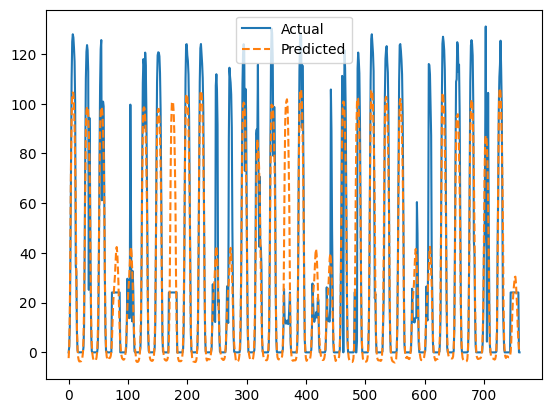

In [123]:
model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch).squeeze()
        predictions.extend(y_pred.tolist())
        actuals.extend(y_batch.tolist())

# Convert back from normalized scale
actuals = scalers["y"].inverse_transform(np.array(actuals).reshape(-1, 1))
predictions = scalers["y"].inverse_transform(np.array(predictions).reshape(-1, 1))

# Plot results
import matplotlib.pyplot as plt

plt.plot(actuals, label="Actual")
plt.plot(predictions, label="Predicted", linestyle="dashed")
plt.legend()
plt.show()

In [128]:
aux = generation.iloc[-24:].drop(["ds", "y"], axis=1).values
last_seq = torch.tensor(aux, dtype=torch.float32).unsqueeze(0)
len(last_seq)

1

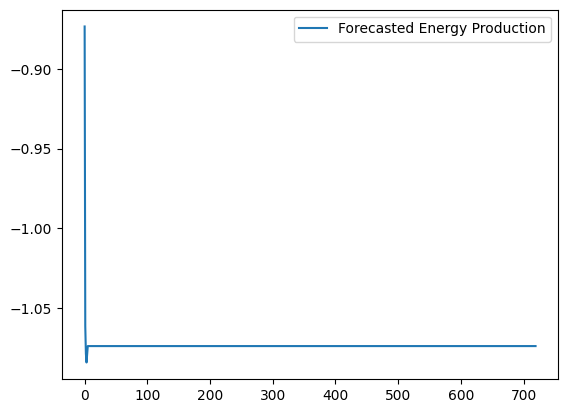

array([[-0.873255  ],
       [-1.06156374],
       [-1.07891015],
       [-1.0844247 ],
       [-1.07945522],
       [-1.07411857],
       [-1.07411857],
       [-1.07411857],
       [-1.07411857],
       [-1.07411857],
       [-1.07411857],
       [-1.07411857],
       [-1.07411857],
       [-1.07411857],
       [-1.07411857],
       [-1.07411857],
       [-1.07411857],
       [-1.07411857],
       [-1.07411857],
       [-1.07411857],
       [-1.07411857],
       [-1.07411857],
       [-1.07411857],
       [-1.07411857],
       [-1.07411857],
       [-1.07411857],
       [-1.07411857],
       [-1.07411857],
       [-1.07411857],
       [-1.07411857],
       [-1.07411857],
       [-1.07411857],
       [-1.07411857],
       [-1.07411857],
       [-1.07411857],
       [-1.07411857],
       [-1.07411857],
       [-1.07411857],
       [-1.07411857],
       [-1.07411857],
       [-1.07411857],
       [-1.07411857],
       [-1.07411857],
       [-1.07411857],
       [-1.07411857],
       [-1

In [129]:
def forecast_next_month(model, df, seq_length, steps=24*30):
    model.eval()
    df = df.drop(["ds", "y"], axis=1)
    last_seq = df.iloc[-seq_length:].values
    last_seq = torch.tensor(last_seq, dtype=torch.float32).unsqueeze(0)

    future_preds = []
    for _ in range(steps):
        with torch.no_grad():
            pred = model(last_seq).item()
            future_preds.append(pred)

        # Update sequence for next prediction
        new_row = last_seq[:, 1:, :].clone()  # Shift left
        new_features = torch.tensor(df.iloc[-1].values, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        last_seq = torch.cat((new_row, new_features), dim=1)

    # Convert back from normalized scale
    future_preds = scalers["y"].inverse_transform(np.array(future_preds).reshape(-1, 1))

    return future_preds

future_predictions = forecast_next_month(model, generation, seq_length)

# Plot future predictions
plt.plot(future_predictions, label="Forecasted Energy Production")
plt.legend()
plt.show()
future_predictions


Please review to see if I fucked up or something because these results CANNOT be right

# From here under it's for generating the predicitons.

In [26]:
# Generate timestamps for September
future_dates = pd.date_range(start='2024-09-01 00:00:00', end='2024-09-30 23:00:00', freq='h')

# Create an empty DataFrame for predictions
future_df = pd.DataFrame({'ds': future_dates})

# Convert Timestamp Features
future_df['hour'] = future_df['ds'].dt.hour
future_df['day'] = future_df['ds'].dt.day
future_df['month'] = future_df['ds'].dt.month
future_df['weekday'] = future_df['ds'].dt.weekday
future_df['is_weekend'] = (future_df['weekday'] >= 5).astype(int)

# Apply Cyclical Encoding
future_df['hour_sin'] = np.sin(2 * np.pi * future_df['hour'] / 24)
future_df['hour_cos'] = np.cos(2 * np.pi * future_df['hour'] / 24)

future_df['day_sin'] = np.sin(2 * np.pi * future_df['day'] / 31)
future_df['day_cos'] = np.cos(2 * np.pi * future_df['day'] / 31)

future_df['month_sin'] = np.sin(2 * np.pi * future_df['month'] / 12)
future_df['month_cos'] = np.cos(2 * np.pi * future_df['month'] / 12)

last_known_data = df[df['ds'] >= '2024-08-31'].copy()


In [29]:
# Keep only the required columns for submission
submission_df = future_df[['ds', 'Energia']]

# Save as CSV
submission_filename = 'Challenge1_GroupX.csv'  # Replace 'GroupX' with your team name if needed

#print(f"✅ Submission file saved as '{submission_filename}'")

# Clip the values of 'Energia' column lower than 0.5 to 0
submission_df['Energia'] = submission_df['Energia'].apply(lambda x: 0 if x < 0.5 else x)
submission_df.to_csv(submission_filename, index=False)
submission_df.head(20)


C:\Users\juanf\AppData\Local\Temp\ipykernel_45100\1195972872.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission_df['Energia'] = submission_df['Energia'].apply(lambda x: 0 if x < 0.5 else x)


,ds,Energia
0,2024-09-01 00:00:00,0.000000
1,2024-09-01 01:00:00,0.000000
2,2024-09-01 02:00:00,0.000000
3,2024-09-01 03:00:00,0.000000
4,2024-09-01 04:00:00,0.000000
5,2024-09-01 05:00:00,0.000000
6,2024-09-01 06:00:00,0.000000
7,2024-09-01 07:00:00,0.000000
8,2024-09-01 08:00:00,1.152616
9,2024-09-01 09:00:00,3.624847


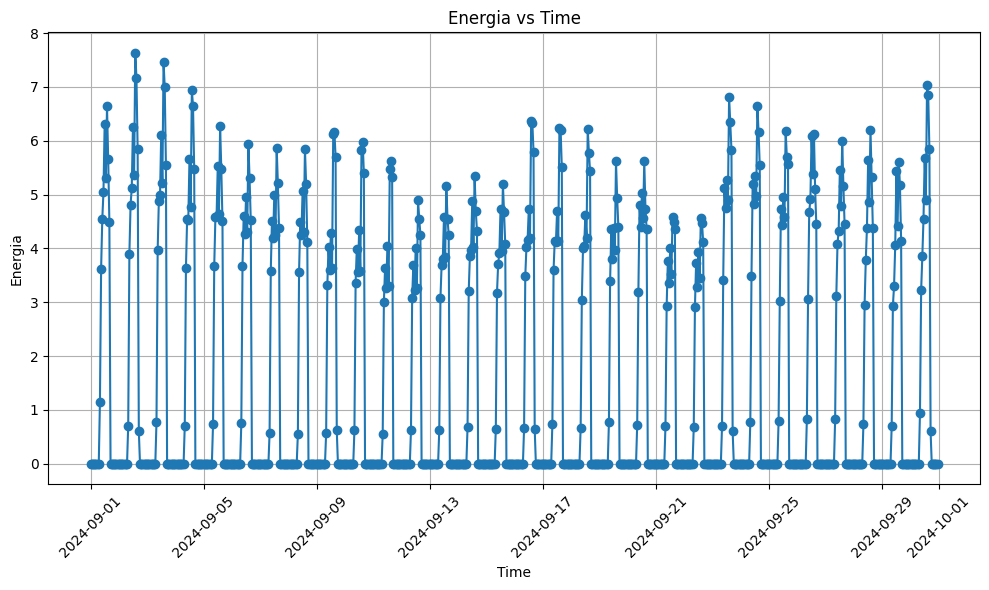

In [30]:
import matplotlib.pyplot as plt

# Plot the values of Energia against time
plt.figure(figsize=(10, 6))
plt.plot(submission_df['ds'], submission_df['Energia'], marker='o', linestyle='-')
plt.xlabel('Time')
plt.ylabel('Energia')
plt.title('Energia vs Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
